# CNN Regression Model

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K

## Sample

<AxesSubplot:title={'center':'Velocity'}>

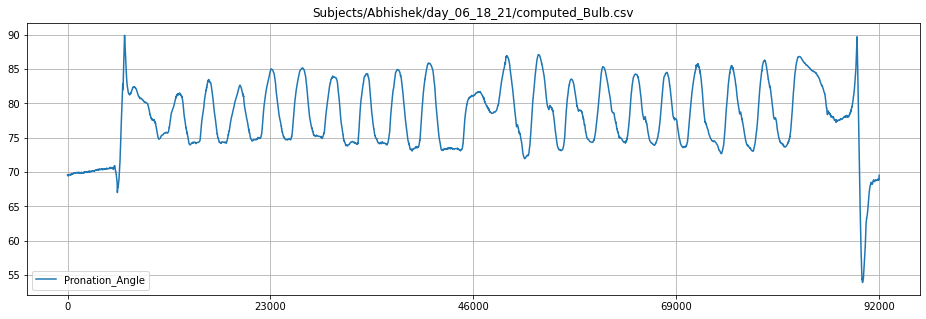

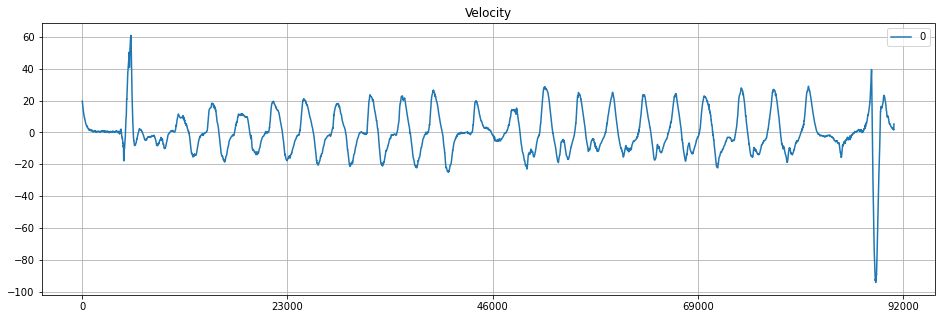

In [2]:
file = 'Subjects/Abhishek/day_06_18_21/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Pronation_Angle']))
arr = arr/(1/2000)
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
sclr = StandardScaler()
# arr = sclr.fit_transform(arr.reshape(-1,1))
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [3]:
window = 400

In [4]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21','Varun/day_06_18_21','Abhishek/day_06_18_21'] #,'Nikhil/day_05_13_21' 'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
#     trial_names = ['Bulb','Screw'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] 
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [5]:
files = files[1:]

In [5]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [6]:
files_df = filter_df(files_df)

In [7]:
X, y = multiple_prep_data_velocity(files_df,window,interval=20,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(151440, 400, 8)

## Time Window Normalize

In [8]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [9]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(121152, 400, 8)
(30288, 400, 8)
(121152, 1)
(30288, 1)


# Neural Network Regression

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [12]:
n_outputs = 1
in_shape = (X.shape[1],X.shape[2])

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=76, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=76, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=76, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=76, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(n_outputs))

# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam',metrics=[])

checkpoint_filepath = 'best_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 398, 256)          6400      
_________________________________________________________________
dropout (Dropout)            (None, 398, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          98432     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 394, 64)           24640     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 392, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 196, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 64)           0

In [ ]:
cnn_history=model.fit(X_train,y_train,epochs = 50,batch_size = 1000,validation_data = (X_test,y_test), callbacks=[model_checkpoint_callback,earlystopping_callback])

In [ ]:
model.save('models/prosup_velocity_model_{}.hdf5'.format(window))

In [ ]:
import matplotlib.pyplot as plt
def plot_model(history):    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['pearson_r'][1:])
#     plt.plot(history.history['val_pearson_r'][1:])
#     plt.title('Model Pearsonr',size=20)
#     plt.ylabel('Pearsonr',size=15)
#     plt.xlabel('Epochs', size=15)
#     plt.legend(['Training', 'Testing'], loc='best')
#     plt.show()

In [ ]:
plot_model(cnn_history)

In [18]:
model = load_model('models/prosup_velocity_model_{}.hdf5'.format(window))

## Model Testing

In [132]:
window = 400
model = load_model('models/prosup_velocity_model_{}.hdf5'.format(400))
# model = load_model('best_model')

ValueError: Unknown metric function: pearson_r. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
df = pd.read_csv(file,index_col=0)

In [ ]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')

In [ ]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [ ]:
pred = model.predict(X)
model.evaluate(X,y)

In [ ]:
plt.figure(figsize=(16,5))
t = np.linspace(0,46,len(pred))
plt.plot(t,pred)
plt.plot(t,y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity (deg/s)',size=15)
plt.xlabel('Time(s)', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

In [ ]:
# pearsonr 0.8

In [ ]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2


def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'correlation_coefficient' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return 1-pearson_r**2
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [ ]:
system_sleep()